In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation, Flatten, ConvLSTM2D, Conv1D, MaxPooling1D, RepeatVector, TimeDistributed, Conv2D, ConvLSTM2D, MaxPool2D, RepeatVector
import keras
import tensorflow
import seaborn as sns
from sklearn.metrics import mean_squared_error


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:

#from google.colab import files
  
  
#uploaded = files.upload()

Saving NIFTY50 - NIFTY50.csv to NIFTY50 - NIFTY50 (1).csv


In [2]:
#import io
#Data=pd.read_csv(io.BytesIO(uploaded['NIFTY50 - NIFTY50.csv']))
Data=pd.read_csv("C:\\Users\\anish\\OneDrive\\Desktop\\Stock Predictor\\LSMT model\\NIFTY50 - NIFTY50.csv")

In [3]:
cols= list(Data)[1:5]
stock_prices = Data[cols].astype(float)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(stock_prices)
stock_prices_scaled = scaler.transform(stock_prices)
print('df_for_training_scaled shape == {}.'.format(stock_prices_scaled.shape))

df_for_training_scaled shape == (3326, 4).


In [5]:
train_size = int(len(stock_prices_scaled) * 0.66)
test_size = len(stock_prices_scaled) - train_size
train, test = stock_prices_scaled[0:train_size,:], stock_prices_scaled[train_size:len(stock_prices_scaled),:]


In [19]:
trainX = []
trainY=[]

In [20]:
n_future = 1   # Number of days we want to predict into the future
n_past = 14   # Number of past days we want to use to predict the future
for i in range(n_past, len(train) - n_future +1):
    trainX.append(train[i - n_past:i, 0:train.shape[1]])
    #train_opening_labels.append(train[i + n_future - 1:i + n_future, 0])
    trainY.append(train[i + n_future - 1:i + n_future, 1])
trainX, trainY = np.array(trainX), np.array(trainY)


In [21]:
print('train_input shape == {}.'.format(trainX.shape))
print('train_closing shape == {}.'.format(trainY.shape))
#input_shape=( trainX.shape[1], trainX.shape[2])
#print(input_shape)

train_input shape == (2181, 14, 4).
train_closing shape == (2181, 1).


In [22]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 12, 64)            832       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               32100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 45,385
Trainable params: 45,385
Non-trainable params: 0
__________________________________________________

In [23]:
history = model.fit(trainX, trainY, epochs = 100, validation_data = (trainX, trainY), batch_size = 32, verbose=1)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp5wlyylum.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp5wlyylum.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - 11s 15ms/step - loss: 0.1024 - val_loss: 0.0030
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.001

In [116]:
training_data_prediction= model.predict(trainX) 
training_data_prediction

array([[-0.9022824 ],
       [-0.9134607 ],
       [-0.87218225],
       ...,
       [ 0.40903   ],
       [ 0.40628305],
       [ 0.40969127]], dtype=float32)

In [117]:
forecast_copies_1 = np.repeat(training_data_prediction, train.shape[1], axis=-1)
predicted_train = scaler.inverse_transform(forecast_copies_1)[:,0]
predicted_train

array([5105.3975, 5074.2217, 5189.3457, ..., 8762.597 , 8754.936 ,
       8764.441 ], dtype=float32)

In [118]:
Train_data=Data[n_past:train_size]
Train_data['Date']=pd.to_datetime(Train_data['Date'])
training_forecast = pd.DataFrame( {'Date':Train_data['Date'],'Close':Train_data['Close'],'Forecast':predicted_train})
train_graph=training_forecast.set_index('Date')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


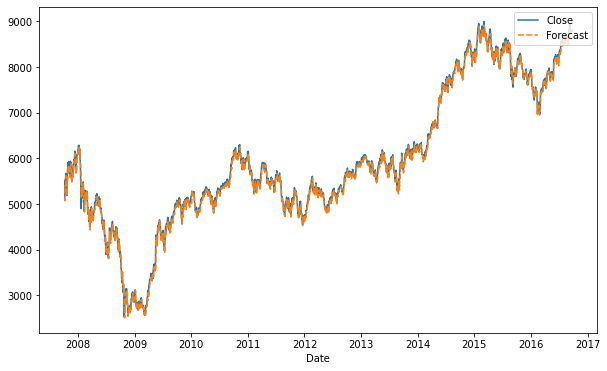

In [119]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=train_graph)
ax.legend (loc="upper right")

In [120]:
import math
trainScore = math.sqrt(mean_squared_error(train_graph['Close'], train_graph['Forecast']))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 86.29 RMSE


In [121]:
test_inputs=[]
for i in range(n_past, len(test) - n_future +1):
    test_inputs.append(test[i - n_past:i, 0:train.shape[1]])
test_inputs=np.array(test_inputs)

In [124]:
testing_data_prediction= model.predict(test_inputs) 
forecast_copies_2 = np.repeat(testing_data_prediction, test.shape[1], axis=-1)
predicted_test = scaler.inverse_transform(forecast_copies_2)[:,0]
predicted_test

array([ 8559.079,  8548.563,  8527.851, ..., 14158.787, 14330.21 ,
       14469.578], dtype=float32)

In [125]:
Test_data=Data[train_size+n_past:len(stock_prices_scaled)]
Test_data['Date']=pd.to_datetime(Test_data['Date'])
testing_forecast = pd.DataFrame( {'Date':Test_data['Date'],'Close':Test_data['Close'],'Forecast':predicted_test})
test_graph=testing_forecast.set_index('Date')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


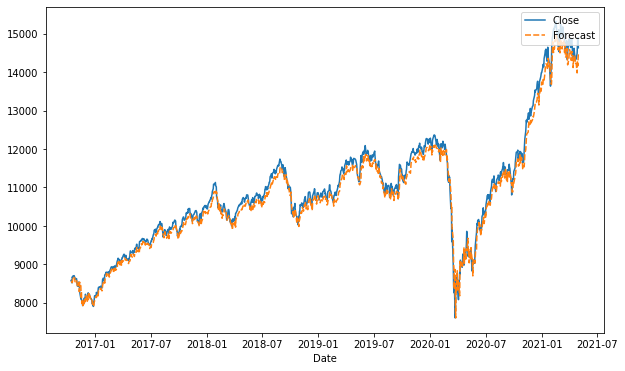

In [126]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=test_graph)
ax.legend (loc="upper right")

In [127]:
import math
testScore = math.sqrt(mean_squared_error(test_graph['Close'], test_graph['Forecast']))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 210.67 RMSE
